# Feature engineering

**Purpose of script:**

Creating new features 

- In: dataframe_plain
- Out: dataframe_extended (with additional feature columns)

In [1]:
import xarray
import rasterio
import gemgis as gg
import pandas as pd
import numpy as np
from tqdm import tqdm
from astral.sun import sun
from astral import LocationInfo
import pyproj
from math import asin, cos, atan, tan, pi, acos, sin 
import os

import datetime as dt

from os import listdir
from os.path import isfile, join
import scipy

##### Relevant paths

In [2]:
path_dataframe_plain = r"../Data/combined/dataframe_plain/"
mw_path = r"../Data/microwave-rs/mw_interpolated/"
path_elevation =  r"../Data/elevation_data/gimpdem_1km_compressed.tif"
path_daylight = r"../Data/daylight_data/"
out_path = r"../Data/combined/dataframe_extended/"

## Features

##### Row and column

In [3]:
def add_row_and_col(df):
        # add row and column features:
        df['col'] = df.groupby("x").ngroup() # xshape 2663 
        df['row'] = df.groupby("y").ngroup(ascending=False) # yshape 1462
        return df

##### Date

In [4]:
def add_date(df, melt_date):
    date = pd.to_datetime(melt_date).date()
    df['date'] = date
    return df

##### Aggregated/pooled values

In [5]:
from typing import Union
from typing import Tuple
from scipy.stats import mode
from scipy.signal import convolve2d

def get_window(image: np.ndarray, window_size: int, center: Tuple[int, int]) -> np.ndarray:
    top = max(center[0] - window_size // 2, 0)
    bottom = min(center[0] + window_size // 2 + 1, image.shape[0])
    left = max(center[1] - window_size // 2, 0)
    right = min(center[1] + window_size // 2 + 1, image.shape[1])
    window = image[top:bottom, left:right]
    return window


# need to fix? : only calculate if the middle value is not nan - else all nan columns around 1 and 0 are going to have a value.

def convolve(image, window_size, convolution_fn: Union['mean', 'min', 'max', 'sum']):
    image = image[0].values
    image[image == -1] = np.nan
    
    if convolution_fn == 'mean':
        kernel = np.ones((window_size, window_size))  # kernel for mean convolution
        result = np.zeros_like(image, dtype=np.float64)
        # Compute the sum and count of non-NaN values in the kernel window
        counts = convolve2d(~np.isnan(image), kernel, mode='same', boundary='fill', fillvalue=0)
        sums = convolve2d(np.nan_to_num(image), kernel, mode='same', boundary='fill', fillvalue=0)
        # Calculate the mean, ignoring NaN values
        result[counts > 0] = sums[counts > 0] / counts[counts > 0]
        # Set the output to NaN where all values in the kernel window are NaN
        result[counts == 0] = np.nan
        return result
        
    elif convolution_fn == 'max':
        result = np.zeros_like(image, dtype=np.float64)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                window = get_window(image, window_size, (i, j))
                non_nan_values = window[~np.isnan(window)]
                if len(non_nan_values) == 0:
                    result[i, j] = np.nan
                else:
                    result[i, j] = np.nanmax(non_nan_values)

    elif convolution_fn == 'min':
        result = np.zeros_like(image, dtype=np.float64)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                window = get_window(image, window_size, (i, j))
                non_nan_values = window[~np.isnan(window)]
                if len(non_nan_values) == 0:
                    result[i, j] = np.nan
                else:
                    result[i, j] = np.nanmin(non_nan_values)
        return result

    elif convolution_fn == 'sum':
        result = np.zeros_like(image, dtype=np.float64)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                window = get_window(image, window_size, (i, j))
                non_nan_values = window[~np.isnan(window)]
                if len(non_nan_values) == 0:
                    result[i, j] = np.nan
                else:
                    result[i, j] = np.nansum(non_nan_values)
        return result
        
    else: 
        print('not available function')
    return

In [6]:
def convolution_to_df(convolution_raster, column_name):
    nrows, ncols = convolution_raster.shape
    # create an array of x and y positions
    x = np.tile(np.arange(ncols), nrows)
    y = np.repeat(np.arange(nrows), ncols)
    # create a DataFrame with x, y, and pixel values as columns
    df = pd.DataFrame({'col': x, 'row': y, column_name: convolution_raster.flatten()})

    return df 

##### Elevation data

In [7]:
def add_elevation(data):
    df = data.to_dataframe()
    df = df.reset_index()
    df = df[['x', 'y', 'band_data']]
    df.rename({'band_data': 'elevation_data'}, axis=1, inplace=True)
    return df

##### Slope

Slope is given as degree of incline angle: 0 means flat (no slope == horizontal), 90 means (most possible slope == vertical)

In [39]:
def get_slope(data):
    slope = gg.raster.calculate_slope(data)
    nrows, ncols = slope.shape
    # create an array of x and y positions
    x = np.tile(np.arange(ncols), nrows)
    y = np.repeat(np.arange(nrows), ncols)
    # create a DataFrame with x, y, and pixel values as columns
    df_slope = pd.DataFrame({'col': x, 'row': y, 'slope_data': slope.flatten()})
    return df_slope

##### Aspect

Aspect is given as cosine radian: 0 and 360 degree = 1, 180 degree = -1

In [9]:
def get_aspect(data):
    aspect = gg.raster.calculate_aspect(data)
    nrows, ncols = aspect.shape
    # create an array of x and y positions
    x = np.tile(np.arange(ncols), nrows)
    y = np.repeat(np.arange(nrows), ncols)
    # create a DataFrame with x, y, and pixel values as columns
    df_aspect = pd.DataFrame({'col': x, 'row': y, 'aspect_data': aspect.flatten()})
    df_aspect["aspect_data"] = np.cos(df_aspect["aspect_data"] * np.pi / 180.)
    return df_aspect

##### Distance from margin/shore

In [10]:
def distance_to_margin():
    data_microwave = xarray.open_dataarray(mw_path + '2019-06-08_mw.tif') # any microwave file
    mw_val_masked = data_microwave[0].values
    mw_val_masked = np.copy(mw_val_masked)
    mw_val_masked[mw_val_masked==1]=0
    dist_in_pixels = scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0, return_distances= True)
    return dist_in_pixels

##### Array to DF

In [11]:
def array_to_df(convolution_raster, column_name):
    nrows, ncols = convolution_raster.shape
    # create an array of x and y positions
    x = np.tile(np.arange(ncols), nrows)
    y = np.repeat(np.arange(nrows), ncols)
    # create a DataFrame with x, y, and pixel values as columns
    df = pd.DataFrame({'col': x, 'row': y, column_name: convolution_raster.flatten()})
    return df 

#### Hours of Daylight

In [12]:
def add_hours_of_daylight(df, melt_date):
    date = pd.to_datetime(melt_date)
    day = date.dayofyear
    month = date.month
    # read daylight data for respective month
    daylight = pd.read_parquet(path_daylight + f'hours_of_daylight_month{month}.parquet')
    # only keep column for respective day of year
    daylight = daylight[["x", "y", f'daylight_day_{day}']]
    # rename column "daylight_day_XXX" to "hours_of_daylight"
    daylight.rename({f'daylight_day_{day}': 'hours_of_daylight'}, axis=1, inplace=True)
    return daylight
   

#### Temporal Information

*Note for testing: requires feature-engineered files of 7 days prior to testing date as input*

In [13]:
def add_temporal_information(df, melt_date):

    df_temporal = df[["x", "y"]].copy()

    today = pd.to_datetime(melt_date)
    yesterday = (today - dt.timedelta(days=1)).date()
    file_path_yesterday = f"{out_path}melt_{yesterday}_extended.parquet.gzip"

    if os.path.isfile(file_path_yesterday):
        df_yesteday = pd.read_parquet(file_path_yesterday)
        df_temporal["mw_value_yesterday"] = df_yesteday["mw_value"]
        # df_temporal = df_temporal.join(df_yesterday[["mw_value", "mean_3", "mean_9", "sum_5"]].add_suffix("_yesterday"))

        last_7_days = pd.date_range((today - dt.timedelta(days=7)), yesterday).copy()
        file_check = [os.path.isfile(f"{out_path}melt_{f.date()}_extended.parquet.gzip") for f in last_7_days] 

        if all(file_check):
            mw_last_7_days = pd.DataFrame()
            #mean_3_last_7_days = pd.DataFrame()
            #mean_9_last_7_days = pd.DataFrame()
            #sum_5_last_7_days = pd.DataFrame()

            for date in last_7_days:
                temp = pd.read_parquet(f"{out_path}melt_{date.date()}_extended.parquet.gzip")
                mw_last_7_days = pd.concat([mw_last_7_days, temp["mw_value"]], axis=1)
                #mean_3_last_7_days = pd.concat([mean_3_last_7_days, temp["mean_3"]], axis=1)
                #mean_9_last_7_days = pd.concat([mean_9_last_7_days, temp["mean_9"]], axis=1)
                #sum_5_last_7_days = pd.concat([sum_5_last_7_days, temp["sum_5"]], axis=1)

            df_temporal = df_temporal.assign(
                mw_value_7_day_average=mw_last_7_days.mean(axis=1),
                #mean_3_7_day_average=mean_3_last_7_days.mean(axis=1),
                #mean_9_7_day_average=mean_9_last_7_days.mean(axis=1),
                #sum_5_7_day_average=sum_5_last_7_days.mean(axis=1),
            )
        else:
            df_temporal = df_temporal.assign(
                mw_value_7_day_average=np.nan,
                #mean_3_7_day_average=np.nan,
                #mean_9_7_day_average=np.nan,
                #sum_5_7_day_average=np.nan
            )
        return df_temporal
    else:
        nan_df = pd.DataFrame(columns=["x", "y", "mw_value_yesterday", "mw_value_7_day_average"]) # "mean_3_yesterday", "mean_3_7_day_average", "mean_9_yesterday", "mean_9_7_day_average", "sum_3_yesterday", "sum_3_7_day_average"], index=df.index)
        nan_df["x"] = df["x"]
        nan_df["y"] = df["y"]
        return nan_df

## Main:

In [14]:
def get_files(mw_path, path_dataframe_plain):
    # get plain files:
    df_plain_files = [f for f in listdir(path_dataframe_plain) if isfile(join(path_dataframe_plain, f))]
    # microwave files:
    mw_files = [f for f in listdir(mw_path) if isfile(join(mw_path, f))]
    return  mw_files, df_plain_files

In [38]:
def main(mw_files_list, df_plain_files_list, path_elevation, out_path, write = False):
    # get plain files:
    df_plain_files = df_plain_files_list
    # microwave files:
    mw_files = mw_files_list
    # load elevation data:
    data_elevation_xarray = xarray.open_dataarray(path_elevation)
    data_elevation_rasterio = rasterio.open(path_elevation)
    # calculate distance to margin:
    distance_margin = distance_to_margin()

    for df_file in df_plain_files:
        melt_date =  df_file[5:15]
        print(melt_date)
        for mw_file in mw_files:
            if mw_file.startswith(melt_date):
                data_mw = xarray.open_dataarray(mw_path + mw_file)
                df = pd.read_parquet(path_dataframe_plain + df_file)
                # cap outliers above 5 in opt_value column to 5
                df.loc[df['opt_value'] > 5, 'opt_value'] = 5
                # add row and column features:
                df = add_row_and_col(df)
                # get convolutions:
                df_conv_mean_3 = array_to_df(convolve(data_mw, 3, 'mean'), 'mean_3')
                df_conv_mean_9 = array_to_df(convolve(data_mw, 9, 'mean'), 'mean_9')
                df_conv_sum_5 = array_to_df(convolve(data_mw, 5, 'sum'), 'sum_5')
                # merge convolution:
                df_combined = pd.merge(df, df_conv_mean_3, how = 'left', on = ['row', 'col'])
                df_combined = pd.merge(df_combined, df_conv_mean_9, how = 'left', on = ['row', 'col'])
                df_combined = pd.merge(df_combined, df_conv_sum_5, how = 'left', on = ['row', 'col'])
                # remove water in mw:
                df_combined = df_combined.loc[df_combined['mw_value'] != -1]
                # add date:
                df = add_date(df_combined, melt_date)
                # add temporal information:
                df_temporal = add_temporal_information(df, melt_date)
                df = pd.merge(df, df_temporal, how = 'left', on = ["y",'x'])
                # add and merge daylight_data:
                df_daylight = add_hours_of_daylight(df, melt_date)
                df = pd.merge(df, df_daylight, how = 'left', on = ["y",'x'])
                # add and merge elevation data:
                df_elevation = add_elevation(data_elevation_xarray)
                df = pd.merge(df, df_elevation, how = 'left', on = ['y', 'x'])
                # get and merge slope data:
                df_slope = get_slope(data_elevation_rasterio)
                df = pd.merge(df, df_slope, how="left", on=["col", "row"])
                # get and merge aspect data:
                df_aspect = get_aspect(data_elevation_rasterio)
                df = pd.merge(df, df_aspect, how="left", on=["col", "row"]) 
                # add and merge distance to margin data:
                df_distance = array_to_df(distance_margin, 'distance_to_margin')
                df = pd.merge(df, df_distance, how = 'left', on = ['row', 'col'])
                # write to parquet:
                if write == True:
                    df.to_parquet(out_path + 'melt_'+ melt_date + '_extended.parquet.gzip', index= False)                    
    return df
                
                

Main

In [ ]:
#main(mw_path, path_dataframe_plain, path_elevation, out_path)
main(*get_files(mw_path, path_dataframe_plain), path_elevation, out_path)# , write = True)

## Testing

In [49]:
df = main(['2019-06-12_mw.tif'], ['melt_2019-06-12.parquet.gzip'], path_elevation, out_path, write= True)
df

2019-06-12


,x,y,mw_value,opt_value,col,row,mean_3,mean_9,sum_5,date,mw_yesterday,mw_value_7_day_average,hours_of_daylight,elevation_data,slope_data,aspect_data,distance_to_margin
0,-636500.00,-662500.00,0.00,-1.00,0,0,0.00,0.00,0.00,2019-06-12,0.00,NaN,24.00,14.00,0.00,1.00,150.00
1,-635500.00,-662500.00,0.00,-1.00,1,0,0.00,0.00,0.00,2019-06-12,0.00,NaN,24.00,14.00,0.00,1.00,150.00
2,-634500.00,-662500.00,0.00,-1.00,2,0,0.00,0.00,0.00,2019-06-12,0.00,NaN,24.00,14.00,0.00,1.00,150.00
3,-633500.00,-662500.00,0.00,-1.00,3,0,0.00,0.00,0.00,2019-06-12,0.00,NaN,24.00,14.00,0.00,1.00,150.00
4,-632500.00,-662500.00,0.00,-1.00,4,0,0.00,0.00,0.00,2019-06-12,0.00,NaN,24.00,14.00,0.00,1.00,150.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278720,58500.00,-3324500.00,0.00,-1.00,695,2662,0.00,0.00,0.00,2019-06-12,0.00,NaN,18.53,44.00,6.48,0.02,5.00
2278721,59500.00,-3324500.00,0.00,-1.00,696,2662,0.00,0.00,0.00,2019-06-12,0.00,NaN,18.53,44.00,0.63,1.00,4.00
2278722,60500.00,-3324500.00,0.00,-1.00,697,2662,0.00,0.00,0.00,2019-06-12,0.00,NaN,18.53,44.00,0.04,0.71,3.00
2278723,61500.00,-3324500.00,0.00,-1.00,698,2662,0.00,0.00,0.00,2019-06-12,0.00,NaN,18.53,45.00,0.03,-0.00,2.00


In [19]:
df.describe()

,x,y,mw_value,opt_value,col,row,mean_3,mean_9,sum_5,mw_yesterday,mw_value_7_day_average,hours_of_daylight,elevation_data,slope_data,aspect_data,distance_to_margin
count,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00,0.00,2278725.00,2278725.00,2278725.00,2278725.00,2278725.00
mean,64496.76,-1807740.05,0.34,-0.27,701.00,1145.24,0.34,0.34,8.46,0.15,NaN,23.50,1717.33,1.33,0.43,164.67
std,317754.06,655887.43,0.48,0.83,317.75,655.89,0.47,0.46,11.70,0.35,NaN,1.29,985.84,3.48,0.65,125.98
min,-636500.00,-3324500.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,18.53,8.00,0.00,-1.00,1.00
25%,-179500.00,-2307500.00,0.00,-1.00,457.00,604.00,0.00,0.00,0.00,0.00,NaN,24.00,877.00,0.00,-0.02,55.15
50%,51500.00,-1773500.00,0.00,-1.00,688.00,1111.00,0.00,0.00,0.00,0.00,NaN,24.00,1927.00,0.15,0.75,138.80
75%,305500.00,-1266500.00,1.00,0.34,942.00,1645.00,1.00,1.00,25.00,0.00,NaN,24.00,2553.00,0.59,1.00,254.87
max,824500.00,-662500.00,1.00,5.00,1461.00,2662.00,1.00,1.00,25.00,1.00,NaN,24.00,3499.00,50.83,1.00,496.01


<AxesSubplot: xlabel='opt_value', ylabel='Density'>

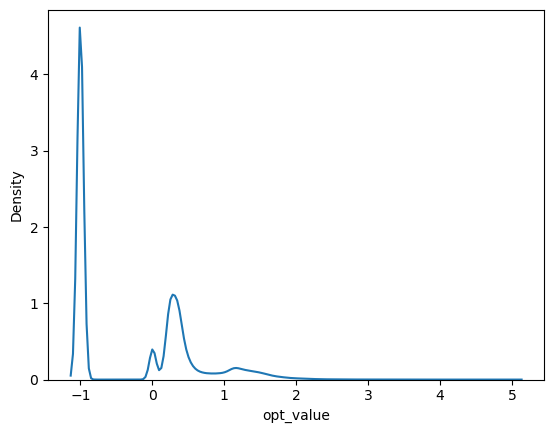

In [34]:
sns.kdeplot(df['opt_value'])

<AxesSubplot: xlabel='hours_of_daylight', ylabel='Density'>

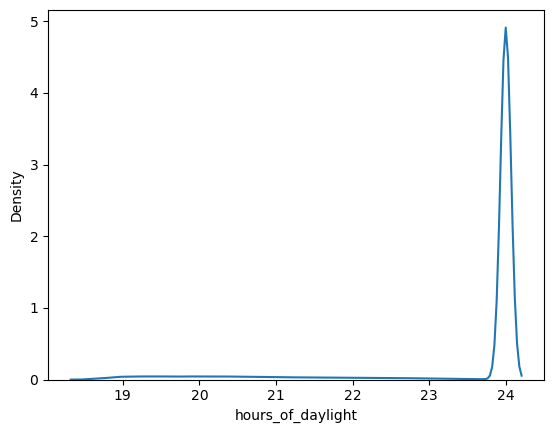

In [35]:
sns.kdeplot(df['hours_of_daylight'])

<AxesSubplot: xlabel='elevation_data', ylabel='Density'>

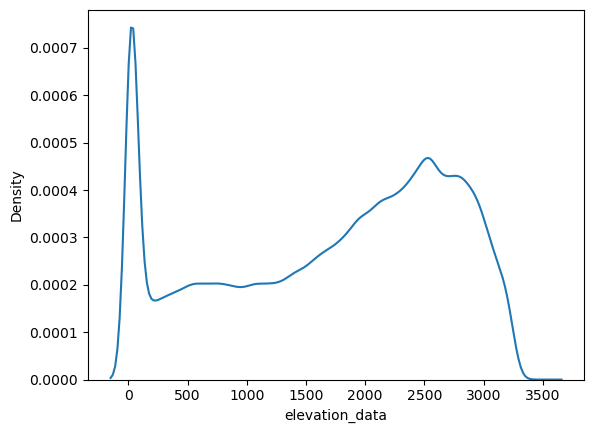

In [36]:
sns.kdeplot(df['elevation_data'])

<AxesSubplot: xlabel='slope_data', ylabel='Density'>

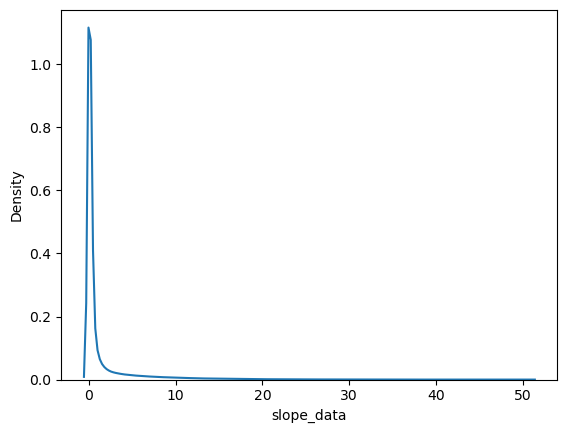

In [37]:
sns.kdeplot(df['slope_data'])

<AxesSubplot: xlabel='aspect_data', ylabel='Density'>

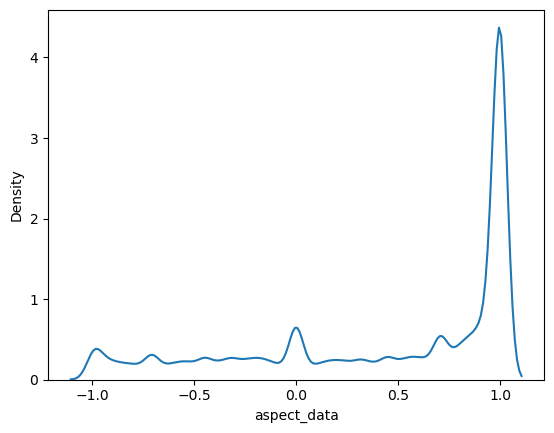

In [38]:
sns.kdeplot(df['aspect_data'])

<AxesSubplot: xlabel='distance_to_margin', ylabel='Density'>

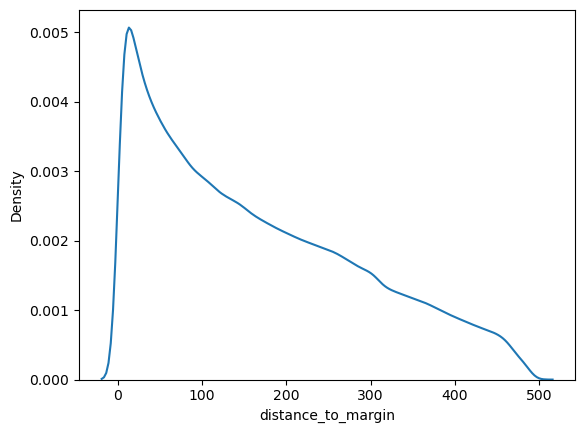

In [39]:
sns.kdeplot(df['distance_to_margin'])

In [35]:
# # for testing values around the 0-1 change in the data:

# tt = data_mw.values
# # indices = np.where(tt == 1)
# tt[0][74:80, 622:628]